In [378]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import networkx as nx
import matplotlib as mpl

In [379]:
# Import aircraft info
aircraft_info = pd.read_excel('Aircraft_fleet_info.xlsx')

# Transpose the dataframe 
aircraft_info = aircraft_info.T

# Promote the first row to column headers and drop the first row
aircraft_info.reset_index(inplace=True)
aircraft_info.columns = aircraft_info.iloc[0]
aircraft_info = aircraft_info.drop(aircraft_info.index[0])

# Split the Aircraft Type column into two columns at : and drop the original column and rename the new columns
aircraft_info[['Aircraft Type', 'Aircraft Type Name']] = aircraft_info['Aircraft Type'].str.split(':', expand=True)
aircraft_info.set_index('Aircraft Type', inplace=True)

# Make it a dictionary for each aircraft type
aircraft_info = aircraft_info.to_dict('index')

# Add kerosen flag to the dictionary
aircraft_info['Type 1']['Electric'] = 0
aircraft_info['Type 2']['Electric'] = 1
aircraft_info['Type 3']['Electric'] = 1

# Make a list of aircraft types
aircraft_types = list(aircraft_info.keys())


In [380]:
# Import distances 
distances = pd.read_csv('Group_4Regional_Distances.csv')

# Rename the unammed column to 'Origin'
distances.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)
distances.set_index('Origin', inplace=True)

# Make it a dictionary
distances = distances.to_dict()

In [381]:
# Import airport info 
airport_info = pd.read_csv('Group_4Regional_Airport_info.csv')

hub = airport_info['ICAO Code'].iloc[0]

# Make it a dictionary using the ICAO code as the key and the rest of the info in a sub-dictionary
airport_info = airport_info.set_index('ICAO Code').T.to_dict('dict')

# Create a list of the airport ICAO codes
airport_list = list(airport_info.keys())

aiport_loc = {}
for e, i in enumerate(reversed(airport_list)):
    aiport_loc[i] = e


In [382]:
# Import demand data
daily_demand = pd.read_csv('Group_4Regional_Demand.csv')
daily_demand.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)
daily_demand.set_index('Origin', inplace=True)
daily_demand = daily_demand.to_dict('index')

In [383]:
# Import the houly coefficients
hourly_coefficients = pd.read_csv('Group_4Hourly_coefficients.csv')
hourly_coefficients.rename(columns={'Unnamed: 0':'id', 'Unnamed: 1':'Origin Name', 'Unnamed: 2':'Origin ICAO'}, inplace=True)
hourly_coefficients.drop(columns=['id','Unnamed: 0.1','Origin Name'], inplace=True)
hourly_coefficients.set_index('Origin ICAO', inplace=True)

# Compute the hourly demand for each OD pair
hour_demand = {}
for origin in airport_list:
    for destination in airport_list:
        od_demand = daily_demand[origin][destination]
        hour_demand[origin,destination] = hourly_coefficients  * od_demand 

hourly_coefficients = hourly_coefficients.to_dict('index')


In [384]:
# Revenue

''' Create Yield matrix dict from formula in RPK using distance matrix
    Formula: Yield = 5.9 ∙ dij^(−0.76) + 0.043 '''

yield_matrix = {}
for i in airport_list:
    yield_matrix[i] = {}
    for j in airport_list:
        if i == j:
            yield_matrix[i][j] = 0
        else:
            yield_matrix[i][j] = 5.9 * (distances[i][j] ** (-0.76)) + 0.043


In [385]:
# Costs 
# Operational costs

''' Fixed costs = CXk  '''
fixed = {}
for k in aircraft_types:
    fixed[k] = aircraft_info[k]['Fixed Operating Cost (Per Fligth Leg)  [€]']

''' Time based costs i -> j
    Formula: CTkij = cTk ∙ dij / Vk '''
time_based = {}
for k in aircraft_types:
    time_based[k] = {}
    for i in airport_list:
        time_based[k][i] = {}
        for j in airport_list:
            time_based[k][i][j] = aircraft_info[k]['Cost per Hour'] * distances[i][j] / aircraft_info[k]['Speed [km/h]']

''' Fuel costs i -> j
    Formula: CFkij = cFk ∙ dij ∙ f / 1.5'''
fuel_gal_cost = 1.42 
fuel = {}
for k in aircraft_types:
    fuel[k] = {}
    for i in airport_list:
        fuel[k][i] = {}
        for j in airport_list:
            if aircraft_info[k]['Electric'] == 1:
                fuel[k][i][j] = 0
            else:
                fuel[k][i][j] = aircraft_info[k]['Fuel Cost Parameter'] * distances[i][j] * fuel_gal_cost / 1.5

''' Energy costs i -> j
    Formula: CEkij = e ∙ Gk ∙ dij / Rk '''
energy = {}
for k in aircraft_types:
    energy[k] = {}
    for i in airport_list:
        energy[k][i] = {}
        for j in airport_list:
            if aircraft_info[k]['Electric'] == 0:
                energy[k][i][j] = 0
            else:
                energy[k][i][j] = 0.07 * aircraft_info[k]['Batteries energy (kWh)'] * distances[i][j] / aircraft_info[k]['Maximum Range [km]']

''' Total costs i -> j
    Formula: CXk + CTkij + CFkij + CEkij '''
hub_factor = 0.7
op_costs = {}
for k in aircraft_types:
    op_costs[k] = {}
    for i in airport_list:
        op_costs[k][i] = {}
        for j in airport_list:
            if i == hub or j == hub:
                op_costs[k][i][j] = (fixed[k] + time_based[k][i][j] + fuel[k][i][j]) * hub_factor + energy[k][i][j]
            else:
                op_costs[k][i][j] = fixed[k] + time_based[k][i][j] + fuel[k][i][j] + energy[k][i][j]
            if i == j:
                op_costs[k][i][j] = 0
                

In [386]:
''' Time i -> j
    Formula: dij / Vk + TATk + 30 (landing and takeoff) + additional charging time (if electric) '''
times = {}
for k in aircraft_types:
    times[k] = {}
    for i in airport_list:
        times[k][i] = {}
        for j in airport_list:
            times[k][i][j] = {}
            if i == j:
                times[k][i][j] = 0.1
            else:
                times[k][i][j] = math.ceil((distances[i][j] / aircraft_info[k]['Speed [km/h]'] * 60
                                + aircraft_info[k]['Average TAT [min]']
                                + 30
                                + (aircraft_info[k]['Additional charging time'] if aircraft_info[k]['Electric'] == 1 else 0) if i != j else 0) * 10 / 60) / 10

In [387]:
# Create a list of all possible time steps
time_steps = list((np.arange(0, 24, 0.1)))

for i,t in enumerate(time_steps):
    time_steps[i] = round(t, 1)

In [388]:
# Create a demand dictionary for each time step only from and to the hub
hourly_demand = {}
for i in airport_list:
    for j in airport_list:
        if (i == hub or j == hub) and i != j:
            hourly_demand[i,j] = {}
            for t in time_steps:
                hourly_demand[i,j][t] = daily_demand[i][j] * (hourly_coefficients[i][str(math.floor(t))]
                                        + (hourly_coefficients[i][str(math.floor(t-1))] if t >= 1 else 0)
                                        + (hourly_coefficients[i][str(math.floor(t+1))] if t <= 22.9 else 0)
                                        + (hourly_coefficients[i][str(math.floor(t-2))] if t >= 2 else 0))

In [389]:
def incoming_flights(k):
    '''
    Create a dictionary of all possible incoming flights from the hub
    '''
    incoming = {}
    for i in airport_list:
        if i == hub:
            continue
        incoming[i,hub] = {}
        for t in time_steps:
            arrival = round(t + times[k][i][hub],ndigits=1)
            if arrival <= 24:
                if t >= times[k][i][hub]:
                    incoming[i,hub][t, arrival] = {}
                    incoming[i,hub][t, arrival]['pax'] = min(aircraft_info[k]['Seats'], hourly_demand[i,hub][t])
                    incoming[i,hub][t, arrival]['cost'] = op_costs[k][i][hub]
                    incoming[i,hub][t, arrival]['RPK'] = yield_matrix[i][hub]
                    incoming[i,hub][t, arrival]['profit'] = distances[i][hub] * incoming[i, hub][t, arrival]['pax'] * yield_matrix[i][hub] - op_costs[k][i][j]
    return incoming

In [390]:
def outgoing_flights(k):
    '''
    Create a dictionary of all possible outgoing flights from the hub
    '''
    outgoing = {}
    for i in airport_list:
        if i == hub:
            continue
        outgoing[hub,i] = {}
        for t in time_steps:
            arrival = round(t + times[k][hub][i], ndigits=1)
            if arrival <= 24:
                if arrival <= 24 - times[k][hub][i]:
                    outgoing[hub,i][t, arrival] = {}
                    outgoing[hub,i][t, arrival]['pax'] = min(aircraft_info[k]['Seats'], hourly_demand[hub,i][t])
                    outgoing[hub,i][t, arrival]['cost'] = op_costs[k][hub][i]
                    outgoing[hub,i][t, arrival]['RPK'] = yield_matrix[hub][i]
                    outgoing[hub,i][t, arrival]['profit'] = distances[hub][i] * outgoing[hub,i][t, arrival]['pax'] * yield_matrix[hub][i] - op_costs[k][hub][i]
    return outgoing
    

In [391]:
def nodes_and_self_flights(k):
    '''
    Creates a dictionary of nodes and a dictionary of self arcs for each aircraft type
    '''
    nodes_ntwrk = {}
    self_arcs = {}
    for i in airport_list:
        nodes_ntwrk[i] = []
        self_arcs[i,i] = {}
        for t in time_steps:
            arrival = round(t + times[k][i][i], ndigits=1)
            if arrival <= 24 - times[k][hub][i] and t >= times[k][i][hub] or times[k][hub][i] == 0.1:
                self_arcs[i,i][t, arrival] = {0}
                nodes_ntwrk[i].append(t)

    for i in airport_list:
        nodes_ntwrk[i].append(round(max(nodes_ntwrk[i]) + 0.1, ndigits=1))

    return nodes_ntwrk, self_arcs

In [392]:
def define_graph(nodes_ntwrk, incoming, outgoing, self_arcs):
    ''' 
    Creates a directed graph with nodes and edges
    '''
    G = nx.DiGraph()

    # Add nodes
    for i in airport_list:
        for n in nodes_ntwrk[i]:
            G.add_node((n, i), airport=i, pos=np.array([n, aiport_loc[i]]), stage = int(n * 10))

    # Add edges
    for o,d in incoming.keys():
        for t1,t2 in incoming[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = incoming[o,d][t1,t2]['profit'], departure = t1, arrival = t2, pax = incoming[o,d][t1,t2]['pax'])

    for o,d in outgoing.keys():
        for t1,t2 in outgoing[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = outgoing[o,d][t1,t2]['profit'], departure = t1, arrival = t2, pax = outgoing[o,d][t1,t2]['pax'])

    for o,d in self_arcs.keys():
        for t1,t2 in self_arcs[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = 0, departure = t1, arrival = t2, pax = 0)
    
    stages = {}
    n = 241
    for stage in range(0, n):
        stages[stage] = [node for node in G.nodes() if G.nodes[node]['stage'] == stage]

    return G, stages

In [393]:
def total_profit(G, stages, n):
    f_n_ast = {}
    f_n_ast[240] = {(24.0, hub): 0}
    x_n_ast = {(24.0, hub): []}
    for stage in range(n - 2, -1, -1):
        f_n_s = {}
        for node in stages[stage]:
            for dest in G.successors(node):
                if node not in x_n_ast:
                    x_n_ast[node] = []
                if node in f_n_s:
                    if f_n_s[node] < f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']:
                        x_n_ast[node] = [dest]
                    elif f_n_s[node] == f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']:
                        x_n_ast[node].append(dest)
                    f_n_s[node] = max(f_n_s[node], f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight'])
                else:
                    f_n_s[node] = f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']
                    x_n_ast[node].append(dest)
                f_n_ast[stage] = f_n_s
    return f_n_ast, x_n_ast

In [394]:
# Define the function to find all paths
def find_all_paths(ast, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    
    paths = []
    for node in ast[start]:
        if node not in path:
            newpaths = find_all_paths(ast, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths


In [395]:
def itinerary_calculation(final_results, results, best_k):
    # Create a directed graph with nodes and edges
    G_ast = nx.DiGraph()
    for node in final_results['links'].keys():
        G_ast.add_node(node, airport=node[1], pos=np.array([node[0], aiport_loc[node[1]]]), stage = int(node[0] * 10))

    for orig in final_results['links'].keys():
        for dest in final_results['links'][orig]:
            G_ast.add_edge(orig, dest, weight = results[best_k]['graph'][orig][dest]['weight'], departure = orig[0], arrival = dest[0], pax = results[best_k]['graph'][orig][dest]['pax'])

    for stage in final_results['n_profit']:
        for node in final_results['n_profit'][stage]:
            G_ast.nodes[node]['tot_profit'] = final_results['n_profit'][stage][node]

    # Using a greedy algorithm find the itinerary that maximizes the total profit
    orig = (0.0, hub)
    dest = (24.0, hub)
    itinerary = [orig]
    curr = orig
    while curr != dest:
        next = None
        max_cost = -1
        for node in G_ast.successors(curr):
            if G_ast.nodes[node]['tot_profit'] > max_cost:
                next = node
                max_cost = G_ast.nodes[node]['tot_profit']
        itinerary.append(next)
        curr = next
    
    return itinerary, G_ast

In [396]:
# create a function to update the demand after each iteration
def update_demand(itinerary, hourly_demand, G_ast):
    for i in range(len(itinerary) - 1):
        origin = itinerary[i][1]
        destination = itinerary[i+1][1]
        if origin != destination:
            for t in time_steps:
                if t >= itinerary[i][0] and t <= itinerary[i+1][0]:
                    hourly_demand[origin, destination][t] = hourly_demand[origin, destination][t] - G_ast[itinerary[i]][itinerary[i+1]]['pax']
    return hourly_demand


In [397]:
def itinerary_output(itinerary, G_ast):
    # Make a dataframe with the itinerary
    columns = ['Departure time', 'Route', 'Arrival time', 'Passengers','Profit']

    itinerary_df = pd.DataFrame(columns=columns)

    for i in range(1, len(itinerary) - 1):
        itinerary_df.loc[i] = [
            itinerary[i][0], 
            itinerary[i][1] + ' -> ' + itinerary[i+1][1], 
            itinerary[i+1][0], 
            G_ast[itinerary[i]][itinerary[i+1]]['pax'],
            G_ast[itinerary[i]][itinerary[i+1]]['weight']]
        
    # Remove rows with no profit
    itinerary_df = itinerary_df[itinerary_df['Profit'] != 0]
    itinerary_df.reset_index(drop=True, inplace=True)
    # Make the times readable using datetime 
    itinerary_df['Departure time']  = pd.to_datetime(itinerary_df['Departure time'], unit='h').dt.time
    itinerary_df['Arrival time']  = pd.to_datetime(itinerary_df['Arrival time'], unit='h').dt.time

    # Create a new sheet in an excel file with the itinerary and the name k + iteration number
    return itinerary_df

In [398]:
# Run for each aircraft type
def dp_iteration(aircraft_types, hourly_demand, hub, iter):
    print('Iteration ' + str(iter))
    results = {}
    for k in aircraft_types:
        if aircraft_info[k]['Fleet'] > 0:
            results[k] = {}
            incoming = incoming_flights(k)
            outgoing = outgoing_flights(k)
            nodes_ntwrk, self_arcs = nodes_and_self_flights(k)
            G, stages = define_graph(nodes_ntwrk, incoming, outgoing, self_arcs)
            f_n_ast, x_n_ast = total_profit(G, stages, 241)
            print('Total profit for '+ k + ': %0.0f' % f_n_ast[0][(0, hub)])
            results[k]['total profit'] = f_n_ast[0][(0, hub)]
            results[k]['n_profit'] = f_n_ast
            results[k]['links'] = x_n_ast
            results[k]['graph'] = G

    # Keep only the best solution by profit
    best_profit = 0
    for k in aircraft_types:
        if aircraft_info[k]['Fleet'] > 0 and results[k]['total profit'] > best_profit:
                best_profit = results[k]['total profit']
                best_k = k
    
    if best_profit <= 0:
        print('No feasible solution')
        return
    
    # Update the fleet info
    aircraft_info[best_k]['Fleet'] = aircraft_info[best_k]['Fleet'] - 1

    final_results = results[best_k]
    final_results['aircraft type'] = best_k

    itinerary, G_ast = itinerary_calculation(final_results, results, best_k)

    itinerary_df = itinerary_output(itinerary, G_ast)


    # Update the demand
    hourly_demand = update_demand(itinerary, hourly_demand, G_ast)

    return itinerary_df, best_k

In [399]:
total_fleet = int(sum([aircraft_info[k]['Fleet'] for k in aircraft_types]))
writer = pd.ExcelWriter('itineraries.xlsx', engine='xlsxwriter')

for i in range(1, total_fleet+1):
    output_df, best_k = dp_iteration(aircraft_types, hourly_demand, hub, i)
    output_df.to_excel(writer, sheet_name= best_k + '{}'.format(i))

writer.close()

Iteration 1
Total profit for Type 1: 15717
Total profit for Type 2: 11641
Total profit for Type 3: 3218
Iteration 2
Total profit for Type 1: 15336
Total profit for Type 2: 11142
Total profit for Type 3: 3218
Iteration 3
Total profit for Type 1: 15336
Total profit for Type 2: 11142
Total profit for Type 3: 2825
Iteration 4
Total profit for Type 1: 15336
Total profit for Type 2: 11142
Total profit for Type 3: 2685
Iteration 5
Total profit for Type 1: 15336
Total profit for Type 2: 11142
Total profit for Type 3: 2685
Iteration 6
Total profit for Type 2: 11142
Total profit for Type 3: 2685
Iteration 7
Total profit for Type 2: 10798
Total profit for Type 3: 2685
Iteration 8
Total profit for Type 2: 10643
Total profit for Type 3: 2685
Iteration 9
Total profit for Type 3: 2685
Iteration 10
Total profit for Type 3: 2532
Iteration 11
Total profit for Type 3: 2338


In [85]:
self_nodes = []
# From the itinerary list remove the nodes with the same profit as the last 
for i in range(1, len(itinerary) - 1):
    if itinerary[i][0] == round(itinerary[i-1][0] + 0.1, 1)  and itinerary[i][0] == round(itinerary[i+1][0] - 0.1, 1):
        self_nodes.append(itinerary[i])

for node in self_nodes:
    itinerary.remove(node)

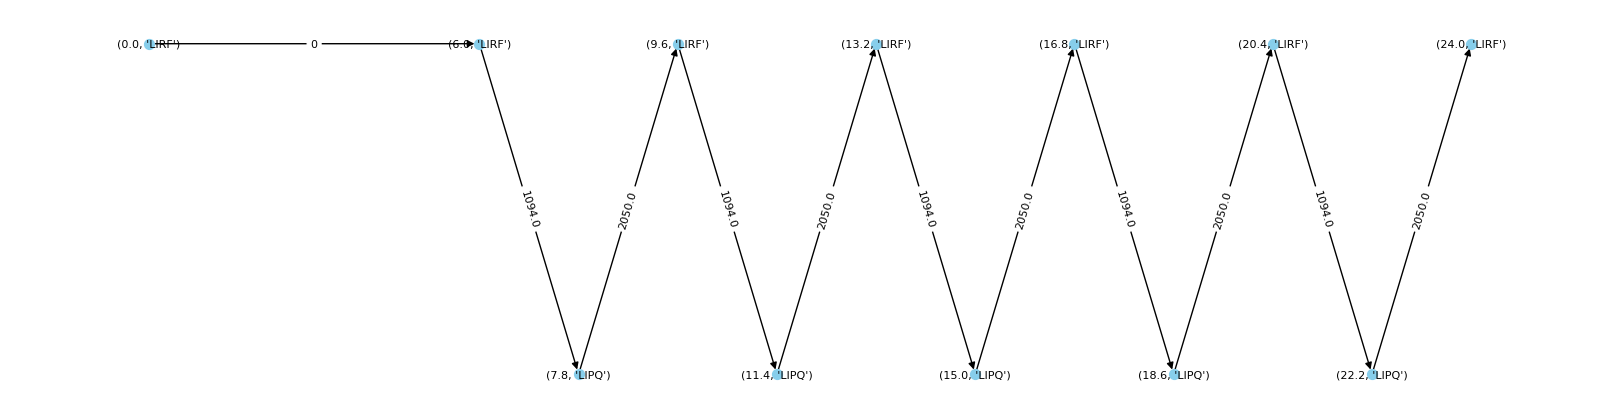

In [86]:
# Plot the itinerary with matplotlib
G_graph = nx.DiGraph()

for node in itinerary:
    G_graph.add_node(node, airport=node[1], pos=np.array([node[0], aiport_loc[node[1]]]))

for i in range(len(itinerary)-1):
    G_graph.add_edge(itinerary[i], itinerary[i+1], departure = itinerary[i][0], arrival = itinerary[i+1][0])
    if (itinerary[i],itinerary[i+1]) in list(G_ast.edges()):
        G_graph[itinerary[i]][itinerary[i+1]]['weight'] = round(G_ast[itinerary[i]][itinerary[i+1]]['weight'],0)
    else:
        G_graph[itinerary[i]][itinerary[i+1]]['weight'] = 0
        

plt.figure(figsize=(16,4))
pos = nx.get_node_attributes(G_graph, 'pos')
nx.draw(G_graph, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='black', linewidths=1, font_size=8, label='Itinerary')
edge_labels = nx.get_edge_attributes(G_graph,'weight')
nx.draw_networkx_edge_labels(G_graph, pos, edge_labels=edge_labels, font_size=8)

plt.show()